In [1]:
# ===============================================================================================
# @des: Ensemble Kalmer Filter: We will later integrate this EnKF with several ICE sheet models.
# @date: 12-09-2024
# @authors: Brian KYANJO and Alex Robel
# ===============================================================================================

In [2]:
# import libraries --------------------------------------------------------------
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm, multivariate_normal
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True) # Set the precision in JAX to use float64

## Steps to follow
- Start with replicating the Julia Code in Python
- This will help in comparing results later 
- After when python agrees with Julia
- Form General Classes for the code to make it more genral using OBP
- Profile the code to see how long the filter takes for very big vlaues of N
- Rewrite the Filter to C and call it in python 
- if Still slow, add parallel capabilities using MPI or OpenMP and still wrap it in python.
- Once this works, now proceed to trying to couple the filter with another problem
- If sucess then, now try with an actual ICE-sheet model
- Continue to remodel and develop the wrapper ....
- Finnally convert the wrapper into a python script

In [3]:
# Parameters definition

def params_define():
    # Prescribed initial values of model parameters in a dictionary
    params = {}
    params["A"]         = 4e-26         
    params["year"]      = 3600 * 24 * 365
    params["n"]         = 3
    params["C"]         = 3e6
    params["rho_i"]     = 900
    params["rho_w"]     = 1000
    params["g"]         = 9.8
    params["B"]         = params["A"] ** (-1 / params["n"])
    params["m"]         = 1 / params["n"]
    params["accum"]     = 0.65 / params["year"]
    params["facemelt"]  = 5 / params["year"]

    # Scaling parameters
    params["hscale"]    = 1000
    params["ascale"]    = 1.0 / params["year"]
    params["uscale"]    = (params["rho_i"] * params["g"] * params["hscale"] * params["ascale"] / params["C"]) ** (1 / (params["m"] + 1))
    params["xscale"]    = params["uscale"] * params["hscale"] / params["ascale"]
    params["tscale"]    = params["xscale"] / params["uscale"]
    params["eps"]       = params["B"] * ((params["uscale"] / params["xscale"]) ** (1 / params["n"])) / (2 * params["rho_i"] * params["g"] * params["hscale"])
    params["lambda"]    = 1 - (params["rho_i"] / params["rho_w"])

    # Grid parameters
    params["NT"]        = 1
    params["TF"]        = params["year"]
    params["dt"]        = params["TF"] / params["NT"]
    params["transient"] = 0
    params["tcurrent"]  = 1

    params["N1"]        = 40
    params["N2"]        = 10
    params["sigGZ"]     = 0.97
    params["NX"]        = params["N1"] + params["N2"]

    # Bed params
    # params["b0"] = -400
    params["xsill"]      = 50e3
    params["sillamp"]    = 500
    params["sillsmooth"] = 1e-5
    # params["bxr"] = 1e-3
    # params["bxp"] = -1e-3

    # EnKF params
    params["inflation"] = 1.0
    params["assim"]     = False

    # Generating sigma values
    sigma1    = np.linspace(params["sigGZ"] / (params["N1"] + 0.5), params["sigGZ"], int(params["N1"]))
    sigma2    = np.linspace(params["sigGZ"], 1, int(params["N2"] + 1))
    sigma     = np.concatenate((sigma1, sigma2[1:params["N2"] + 1]))

    # Create the grid dictionary
    grid                = {"sigma": sigma}
    grid["sigma_elem"]  = np.concatenate(([0], (sigma[:-1] + sigma[1:]) / 2))
    grid["dsigma"]      = np.diff(grid["sigma"])

    return params, grid

In [4]:
# Observation operator ----------------------
def Obs(huxg_virtual_obs, m_obs):
    # Determine the size of the observation vector
    n = huxg_virtual_obs.shape[0]
    m = m_obs

    # Initialize the H matrix with zeros
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Python uses int for integer division

    # Fill in the H matrix
    for i in range(1, m + 1):  # Python's range is 0-based, so start from 1
        H[i - 1, i * di] = 1  # Adjust for 0-based indexing
        H[m + i - 1, int((n - 2) / 2) + i * di] = 1  # Adjust for 0-based indexing

    # Final element of H matrix
    H[m * 2, n - 1] = 1  # Adjust for 0-based indexing

    # Perform matrix multiplication
    z = H @ huxg_virtual_obs  # '@' operator for matrix multiplication in Python
    return z

# Jacobian of the observation operator ----------------------
def JObs(n_model, m_obs):
    # Initialize the H matrix with zeros
    n = n_model
    m = m_obs
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Convert distance to an integer

    # Fill in the H matrix
    for i in range(1, m + 1):  # Python uses 0-based indexing
        H[i - 1, i * di] = 1  # Adjust for 0-based indexing
        H[m + i - 1, int((n - 2) / 2) + i * di] = 1  # Adjust for 0-based indexing

    # Final element of H matrix
    H[m * 2, n - 1] = 1  # Adjust for 0-based indexing

    return H

# EnKF function ------------------------------
def EnKF(huxg_ens, huxg_obs, ObsFun, JObsFun, Cov_obs, Cov_model, params, taper):
    """
    Analysis step of the Ensemble Kalman Filter (EnKF).
    
    huxg_ens: ndarray (n x N) - The ensemble matrix of model states (n is state size, N is ensemble size).
    huxg_obs: ndarray (m,) - The observation vector (m is measurement size).
    ObsFun: Function - Observation function.
    JObsFun: Function - Jacobian of the observation function.
    Cov_obs: ndarray (m x m) - Observation covariance matrix.
    Cov_model: ndarray (n x n) - Model covariance matrix.
    params: dict - Dictionary containing parameters like "m_obs".
    taper: ndarray (n x n) - Covariance taper matrix.
    
    Returns:
    analysis_ens: ndarray (n x N) - The updated ensemble after analysis.
    analysis_cov: ndarray (n x n) - The updated covariance after analysis.
    """
    n, N = huxg_ens.shape  # n is the state size, N is the ensemble size
    m = huxg_obs.shape[0]  # Measurement size (m)

    # Compute the ensemble mean
    huxg_ens_mean = np.mean(huxg_ens, axis=1, keepdims=True)  # mean of model forecast ensemble
    
    # Compute the Jacobian of the observation operator
    Jobs = JObsFun(n, params["m_obs"])  # Jacobian of the observation operator
    
    # Compute the Kalman Gain
    KalGain = Cov_model @ Jobs.T @ np.linalg.inv(Jobs @ Cov_model @ Jobs.T + Cov_obs)

    # Initialize variables
    obs_virtual = np.zeros((m, N))  # Virtual observations for the ensemble
    analysis_ens = np.zeros_like(huxg_ens)  # Analysis ensemble

    # Perform the analysis for each ensemble member
    for i in range(N):
        # Generate virtual observations using multivariate normal distribution
        obs_virtual[:, i] = huxg_obs + multivariate_normal.rvs(mean=np.zeros(m), cov=Cov_obs)

        # Update the ensemble member with the Kalman gain
        analysis_ens[:, i] = huxg_ens[:, i] + KalGain @ (obs_virtual[:, i] - ObsFun(huxg_ens[:, i], params["m_obs"]))
    
    # Compute the mean of the analysis ensemble
    analysis_ens_mean = np.mean(analysis_ens, axis=1, keepdims=True)
    
    # Compute the analysis error covariance
    analysis_cov = (1 / (N - 1)) * (analysis_ens - analysis_ens_mean) @ (analysis_ens - analysis_ens_mean).T
    analysis_cov = analysis_cov * taper  # Apply covariance tapering
    
    return analysis_ens, analysis_cov


In [5]:
# bed topography function --------------------------------------------------------------
def bed(x,params):
    b = params['sillamp'] * (-2 * jnp.arccos((1 - params['sillsmooth']) * jnp.sin(jnp.pi * x / (2 * params['xsill'])))/jnp.pi - 1)
    return b

In [6]:
# Implicit flowline model function (Jax version) --------------------------------------------------------------
def flowline(varin, varin_old, params, grid, bedfun):
    # Unpack grid
    NX          = params["NX"]
    N1          = params["N1"]
    dt          = params["dt"] / params["tscale"]
    ds          = grid["dsigma"]
    sigma       = grid["sigma"]
    sigma_elem  = grid["sigma_elem"]

    # Unpack parameters
    tcurrent    = params["tcurrent"]
    xscale      = params["xscale"]
    hscale      = params["hscale"]
    lambd       = params["lambda"]
    m           = params["m"]
    n           = params["n"]
    a           = params["accum"] / params["ascale"]
    eps         = params["eps"]
    transient   = params["transient"]

    # put a guard on mdot, it could be a scalar or an array
    if isinstance(params["facemelt"], (int, float)):
        mdot = params["facemelt"] / params["uscale"]
    else:
        mdot   = params["facemelt"][tcurrent]/params["uscale"]

    # Unpack variables
    h = varin[0:NX]
    u = varin[NX:2*NX]
    xg = varin[2*NX]

    h_old = varin_old[0:NX]
    xg_old = varin_old[2*NX]


    # Calculate bed 
    hf  = -bedfun(xg * xscale, params) / (hscale * (1 - lambd))
    hfm = -bedfun(xg * sigma_elem[-1] * xscale, params) / (hscale * (1 - lambd))
    b   = -bedfun(xg * sigma * xscale, params) / hscale

    # Initialize the residual vector
    F = jnp.zeros(2 * NX + 1, dtype=jnp.float64)

    # Calculate thickness functions        
    F = F.at[0].set(transient * (h[0] - h_old[0]) / dt + (2 * h[0] * u[0]) / (ds[0] * xg)  - a)
    
    F = F.at[1].set(
        transient * (h[1] - h_old[1]) / dt
        - transient * sigma_elem[1] * (xg - xg_old) * (h[2] - h[0]) / (2 * dt * ds[1] * xg)
        + (h[1] * (u[1] + u[0])) / (2 * xg * ds[1]) - a
    )

    F = F.at[2:NX-1].set(
        transient * (h[2:NX-1] - h_old[2:NX-1]) / dt
        - transient * sigma_elem[2:NX-1] * (xg - xg_old) * (h[3:NX] - h[1:NX-2]) / (2 * dt * ds[2:NX-1] * xg)
        + (h[2:NX-1] * (u[2:NX-1] + u[1:NX-2]) - h[1:NX-2] * (u[1:NX-2] + u[0:NX-3])) / (2 * xg * ds[2:NX-1]) - a
    )

    F = F.at[N1-1].set(
        (1 + 0.5 * (1 + (ds[N1-1] / ds[N1-2]))) * h[N1-1]
        - 0.5 * (1 + (ds[N1-1] / ds[N1-2])) * h[N1-2]
        - h[N1]
    )

    F = F.at[NX-1].set(
    transient * (h[NX-1] - h_old[NX-1]) / dt
    - transient * sigma[NX-1] * (xg - xg_old) * (h[NX-1] - h[NX-2]) / (dt * ds[NX-2] * xg)
    + (h[NX-1] * (u[NX-1] + mdot * hf / h[NX-1] + u[NX-2]) - h[NX-2] * (u[NX-2] + u[NX-3])) / (2 * xg * ds[NX-2])
    - a
    )
    
    # Calculate velocity functions
    F = F.at[NX].set(
        ((4 * eps / (xg * ds[0]) ** ((1 / n) + 1)) * (h[1] * (u[1] - u[0]) * abs(u[1] - u[0]) ** ((1 / n) - 1)
            - h[0] * (2 * u[0]) * abs(2 * u[0]) ** ((1 / n) - 1)))
        - u[0] * abs(u[0]) ** (m - 1)
        - 0.5 * (h[0] + h[1]) * (h[1] - b[1] - h[0] + b[0]) / (xg * ds[0])
    )

    F = F.at[NX+1:2*NX-1].set(
        (4 * eps / (xg * ds[1:NX-1]) ** ((1 / n) + 1))
        * (h[2:NX] * (u[2:NX] - u[1:NX-1]) * abs(u[2:NX] - u[1:NX-1]) ** ((1 / n) - 1)
           - h[1:NX-1] * (u[1:NX-1] - u[0:NX-2]) * abs(u[1:NX-1] - u[0:NX-2]) ** ((1 / n) - 1))
        - u[1:NX-1] * abs(u[1:NX-1]) ** (m - 1)
        - 0.5 * (h[1:NX-1] + h[2:NX]) * (h[2:NX] - b[2:NX] - h[1:NX-1] + b[1:NX-1]) / (xg * ds[1:NX-1])
    )

    F = F.at[NX+N1-1].set((u[N1] - u[N1-1]) / ds[N1-1] - (u[N1-1] - u[N1-2]) / ds[N1-2])
    F = F.at[2*NX-1].set(
        (1 / (xg * ds[NX-2]) ** (1 / n)) * (abs(u[NX-1] - u[NX-2]) ** ((1 / n) - 1)) * (u[NX-1] - u[NX-2])
        - lambd * hf / (8 * eps)
    )

    # Calculate grounding line functions
    F = F.at[2*NX].set(3 * h[NX-1] - h[NX-2] - 2 * hf)

    return F

# Calculate the Jacobian of the flowline model function --------------------------------------------------------------
def Jac_calc(huxg_old, params, grid, bedfun, flowlinefun):
    """
    Use automatic differentiation to calculate Jacobian for nonlinear solver.
    """

    def f(varin):
        # Initialize F as an array of zeros with size 2*NX + 1
        # F = jnp.zeros(2 * params["NX"] + 1, dtype=jnp.float64)
        # Call the flowline function with current arguments
        return flowlinefun(varin, huxg_old, params, grid, bedfun)
        # print(F)
        # return F

    # Create a function that calculates the Jacobian using JAX
    def Jf(varin):
        # Jacobian of f with respect to varin
        return jax.jacfwd(f)(varin)

    return Jf

# Function that runs the flowline model function --------------------------------------------------------------
def flowline_run(varin, params, grid, bedfun, flowlinefun):
    nt = params["NT"]
    huxg_old = varin
    huxg_all = np.zeros((huxg_old.shape[0], nt))

    for i in range(nt):
        if not params["assim"]:
            params["tcurrent"] = i + 1  # Adjusting for 1-based indexing in Julia
        
        # Jacobian calculation
        Jf = Jac_calc(huxg_old, params, grid, bedfun, flowlinefun)
        
        # Solve the system of nonlinear equations
        solve_result = root(
            lambda varin: flowlinefun(varin, huxg_old, params, grid, bedfun), 
            huxg_old, 
            jac=Jf, 
            method='hybr',  # Hybr is a commonly used solver like nlsolve
            options={'maxiter': 100}
        )
        
        # Update the old solution
        huxg_old = solve_result.x
        
        # Store the result for this time step
        huxg_all[:, i] = huxg_old

        if not params["assim"]:
            print(f"Step {i + 1}\n")
    
    return huxg_all

In [7]:
# Initial setup from params_define and initial guess
params, grid = params_define()

# Initial guess and steady-state --------------------------------------------------------------
xg = 300e3 / params["xscale"]
hf = (-bed(xg * params["xscale"], params) / params["hscale"]) / (1 - params["lambda"])
h  = 1 - (1 - hf) * grid["sigma"]
u  = 1.0 * (grid["sigma_elem"] ** (1 / 3)) + 1e-3
huxg_old = np.concatenate((h, u, [xg]))

# call the Jacobian function
Jf = Jac_calc(huxg_old, params, grid, bed, flowline)

# form a wrapper function for the flowline function
def flowline_wrapper(varin):
    # F = np.zeros_like(varin)
    return flowline(varin, huxg_old, params, grid, bed)
    
# Solve the system of nonlinear equations
solve_result = root(flowline_wrapper, huxg_old, jac=Jf, method='hybr', options={'maxfev': 1000})
huxg_out0 = solve_result.x # Extract the solution ".x" from the solver result

In [8]:
# True simulation --------------------------------------------------------------
params["NT"] = 150
params["TF"] = params["year"] * 150
params["dt"] = params["TF"] / params["NT"]
params["transient"] = 1
params["facemelt"] = np.linspace(5, 85, params["NT"] + 1) / params["year"]
fm_dist = np.random.normal(0, 20.0)
fm_truth = params["facemelt"] 
params["facemelt"] = fm_truth
huxg_out1 = flowline_run(huxg_out0, params, grid, bed, flowline)
# huxg_out1 


Step 1

Step 2

Step 3

Step 4

Step 5

Step 6

Step 7

Step 8

Step 9

Step 10

Step 11

Step 12

Step 13

Step 14

Step 15

Step 16

Step 17

Step 18

Step 19

Step 20

Step 21

Step 22

Step 23

Step 24

Step 25

Step 26

Step 27

Step 28

Step 29

Step 30

Step 31

Step 32

Step 33

Step 34

Step 35

Step 36

Step 37

Step 38

Step 39

Step 40

Step 41

Step 42

Step 43

Step 44

Step 45

Step 46

Step 47

Step 48

Step 49

Step 50

Step 51

Step 52

Step 53

Step 54

Step 55

Step 56

Step 57

Step 58

Step 59

Step 60

Step 61

Step 62

Step 63

Step 64

Step 65

Step 66

Step 67

Step 68

Step 69

Step 70

Step 71

Step 72

Step 73

Step 74

Step 75

Step 76

Step 77

Step 78

Step 79

Step 80

Step 81

Step 82

Step 83

Step 84

Step 85

Step 86

Step 87

Step 88

Step 89

Step 90

Step 91

Step 92

Step 93

Step 94

Step 95

Step 96

Step 97

Step 98

Step 99

Step 100

Step 101

Step 102

Step 103

Step 104

Step 105

Step 106

Step 107

Step 108

Step 109

Step 110

Step 111

In [9]:
# Wrongs simulation --------------------------------------------------------------
fm_wrong = np.linspace(5, 45, params["NT"] + 1) / params["year"]
params["facemelt"] = np.linspace(5, 45, params["NT"] + 1) / params["year"]
huxg_out2 = flowline_run(huxg_out0, params, grid, bed, flowline)
# huxg_out2

Step 1

Step 2

Step 3

Step 4

Step 5

Step 6

Step 7

Step 8

Step 9

Step 10

Step 11

Step 12

Step 13

Step 14

Step 15

Step 16

Step 17

Step 18

Step 19

Step 20

Step 21

Step 22

Step 23

Step 24

Step 25

Step 26

Step 27

Step 28

Step 29

Step 30

Step 31

Step 32

Step 33

Step 34

Step 35

Step 36

Step 37

Step 38

Step 39

Step 40

Step 41

Step 42

Step 43

Step 44

Step 45

Step 46

Step 47

Step 48

Step 49

Step 50

Step 51

Step 52

Step 53

Step 54

Step 55

Step 56

Step 57

Step 58

Step 59

Step 60

Step 61

Step 62

Step 63

Step 64

Step 65

Step 66

Step 67

Step 68

Step 69

Step 70

Step 71

Step 72

Step 73

Step 74

Step 75

Step 76

Step 77

Step 78

Step 79

Step 80

Step 81

Step 82

Step 83

Step 84

Step 85

Step 86

Step 87

Step 88

Step 89

Step 90

Step 91

Step 92

Step 93

Step 94

Step 95

Step 96

Step 97

Step 98

Step 99

Step 100

Step 101

Step 102

Step 103

Step 104

Step 105

Step 106

Step 107

Step 108

Step 109

Step 110

Step 111

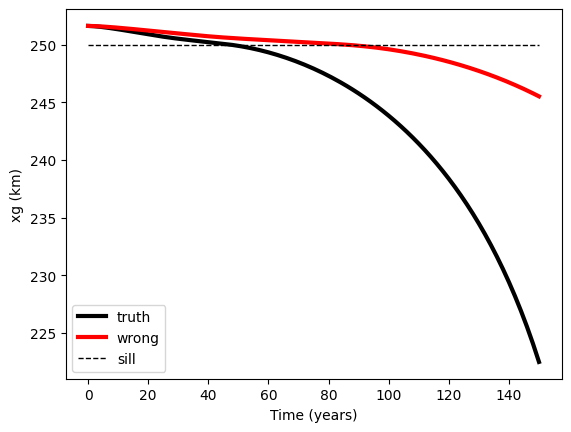

In [10]:
# Time steps array
ts = np.linspace(0, params["TF"] / params["year"], params["NT"] + 1)

# xg_truth and xg_wrong calculations
xg_truth = np.concatenate(([huxg_out0[2 * params["NX"]]], huxg_out1[2 * params["NX"], :])) * params["xscale"]
xg_wrong = np.concatenate(([huxg_out0[2 * params["NX"]]], huxg_out2[2 * params["NX"], :])) * params["xscale"]

# Plotting the results
plt.plot(ts, xg_truth / 1e3, lw=3, color='black', label="truth")
plt.plot(ts, xg_wrong / 1e3, lw=3, color='red', label="wrong")
plt.plot(ts, 250.0 * np.ones_like(ts), lw=1, color='black', linestyle='--', label="sill")

# Add labels and legend
plt.xlabel("Time (years)")
plt.ylabel("xg (km)")
plt.legend()
plt.show()

In [11]:
# Set ensemble parameters --------------------------------------------------------------
statevec_init = np.concatenate((huxg_out0, [params["facemelt"][0] / params["uscale"]]))

# Dimension of model state
nd = statevec_init.shape[0]

# Number of ensemble members
N = 30

# Define the standard deviations for model, observation, and process noise
sig_model = 1e-1
sig_obs = 1e-2
sig_Q = 1e-2

# Initialize the Cov_model matrix
Cov_model = (sig_model**2) * np.eye(nd)

# Initialize the Q matrix
Q = (sig_Q**2) * np.eye(nd)

# Set model parameters for single time step runs
nt = params["NT"]
tfinal_sim = params["TF"]

# Create the time vector 'ts' as in Julia's [(0.0:1.0:params["NT"]);] .* params["year"]
ts = np.arange(0.0, params["NT"] + 1) * params["year"]

# Update parameters for a single time step run
params["NT"] = 1
params["TF"] = params["year"] * 1
params["dt"] = params["TF"] / params["NT"]
params["transient"] = 1
params["assim"] = True  

# Concatenate elements similar to Julia's vcat
statevec_sig = np.concatenate((grid["sigma_elem"], grid["sigma"], np.array([1, 1])))

taper = np.ones((statevec_sig.shape[0], statevec_sig.shape[0]))
taper[-1, -3] = 2  
taper[-3, -1] = 2  
taper[-1, -1] = 10  
taper[-2, -1] = 10  
taper[-1, -2] = 10  

# # Generate synthetic observations of thickness from the "truth" simulation
ts_obs = np.arange(10.0, 140.0 + 1, 10.0) * params["year"]

# Find the indices of ts that match ts_obs (equivalent to findall(in(ts_obs), ts))
idx_obs = np.nonzero(np.isin(ts, ts_obs))[0]

# Define the observation noise distribution (equivalent to Normal(0, sig_obs) in Julia)
obs_dist = norm(loc=0, scale=sig_obs)

# Create virtual observations by vertically concatenating huxg_out1 and fm_truth with added noise
fm_truth_scaled = fm_truth[idx_obs] / params["uscale"]
huxg_virtual_obs = np.vstack((huxg_out1[:, idx_obs], fm_truth_scaled.T))

# Add random noise to the virtual observations
huxg_virtual_obs += obs_dist.rvs(size=huxg_virtual_obs.shape)

# Set the number of observations
params["m_obs"] = 10

nt

150

In [12]:
# Initialize ensemble --------------------------------------------------------------
statevec_bg = np.zeros((nd, nt + 1))        # Background state vector (ub)
statevec_ens_mean = np.zeros((nd, nt + 1))  # Ensemble mean state vector (ua)
mm_ens_mean = np.zeros((nd - 1, nt + 1))    # Ensemble mean minus one dimension (ua)
statevec_ens = np.zeros((nd, N))            # Individual ensemble members (uai)
statevec_ens_full = np.zeros((nd, N, nt + 1)) # Full ensemble for all timesteps (uae)

# Set initial conditions
statevec_bg[:, 0] = statevec_init
statevec_ens_mean[:, 0] = statevec_init

# Initialize the ensemble with perturbations
for i in range(N):
    # Sample from a multivariate normal distribution
    perturbed_state = multivariate_normal.rvs(mean=np.zeros(nd-1), cov=Cov_model[:-1, :-1])
    
    # Assign the perturbed state to the ensemble, excluding the last element
    statevec_ens[:-1, i] = statevec_init[:-1] + perturbed_state
    
    # Keep the last element unchanged
    statevec_ens[-1, i] = statevec_init[-1]

# Store the ensemble initialization for the first timestep
statevec_ens_full[:, :, 0] = statevec_ens

# statevec_ens_full[:, :, 0]

In [13]:
nt

150

In [18]:
# Run Ensemble with assimilation (note obs available at only some time steps) --------------------------------------------------------------
for k in range(nt):
    params["tcurrent"] = k + 1
    print(f"Step {k+1}\n")
    
    # Forecast
    statevec_bg[:-1, k+1] = np.squeeze(flowline_run(statevec_bg[:-1, k], params, grid, bed, flowline)) # background trajectory (without correction)

    statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

    # forecast ensemble
    for i in range(N):
        huxg_temp = np.squeeze(flowline_run(statevec_ens[:-1, i], params, grid, bed, flowline))
        nos = np.random.multivariate_normal(np.zeros(nd), Q)  # Process noise

        # Update state ensemble with noise and forecast
        statevec_ens[:, i] = np.concatenate([huxg_temp, [params["facemelt"][k+1] / params["uscale"]]]) + nos

    # Compute the mean of the analysis ensemble
    statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

    # Check for observations at time step k+1
    if ts[k+1] in ts_obs:
        idx_obs = np.where(ts[k+1] == ts_obs)[0]

        # Forecast error covariance matrix
        diff = statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N)
        Cov_model = (1/(N-1)) * diff @ diff.T
        Cov_model *= taper

        # Measurement noise covariance
        Cov_obs = (sig_obs**2) * np.eye(2 * params["m_obs"] + 1)

        # Subsample virtual observations to actual measurement locations
        huxg_obs = Obs(huxg_virtual_obs[:, idx_obs], params["m_obs"])

        # flatten huxg_obs
        huxg_obs = huxg_obs.ravel()

        # Analysis corrections
        statevec_ens_temp, Cov_model = EnKF(statevec_ens, huxg_obs, Obs, JObs, Cov_obs, Cov_model, params, taper)

        statevec_ens = statevec_ens_temp
        statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

        # Inflate ensemble spread
        statevec_ens = np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N) + params["inflation"] * (statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N))

        # Update facemelt parameter for future steps
        params["facemelt"][k+1:] = statevec_ens_mean[-1, k+1] * params["uscale"] * np.ones_like(params["facemelt"][k+1:])

    # Store full ensemble for the current time step
    statevec_ens_full[:, :, k+1] = statevec_ens

Step 1

Step 2

Step 3

Step 4

Step 5

Step 6

Step 7

Step 8

Step 9

Step 10

Step 11

Step 12

Step 13

Step 14

Step 15

Step 16

Step 17

Step 18

Step 19

Step 20

Step 21

Step 22

Step 23

Step 24

Step 25

Step 26

Step 27

Step 28

Step 29

Step 30

Step 31

Step 32

Step 33



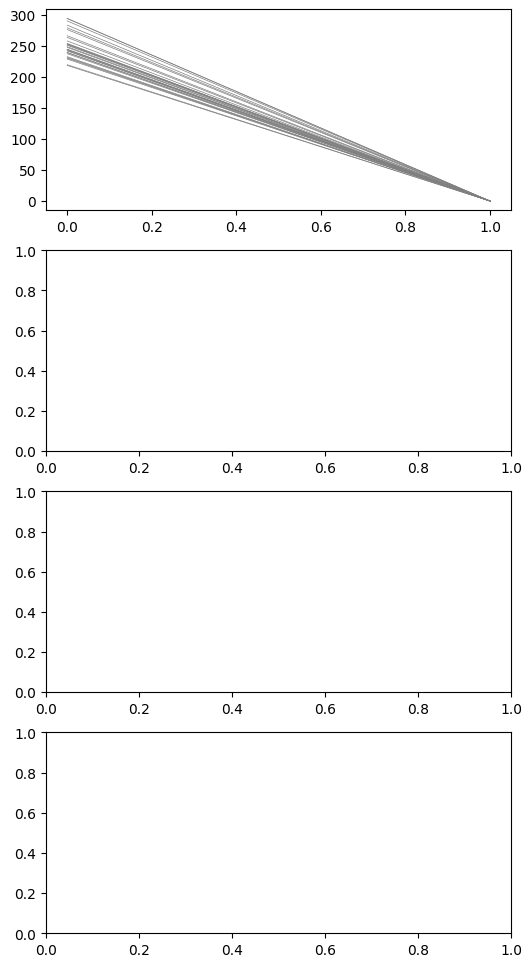

In [57]:
# Plotting the results
# Plot configuration
fig, axes = plt.subplots(4, 1, figsize=(6, 12))

# 1. Plot Grounding Line (GL) position
xg_idx = 2 * params["NX"]
xg_truth = np.concatenate(([huxg_out0[xg_idx]], huxg_out1[xg_idx, :])) * params["xscale"]
xg_wrong = np.concatenate(([statevec_init[xg_idx]], huxg_out2[xg_idx, :])) * params["xscale"]
xg_EnKF_ens_mean = statevec_ens_mean[xg_idx, :] * params["xscale"]
xg_EnKF_ens = statevec_ens_full[xg_idx, :, :].T * params["xscale"]
xg_obs = Obs(huxg_virtual_obs, params["m_obs"])[-1, :] * params["xscale"]

axes[0].plot(ts / params["year"], xg_EnKF_ens / 1e3, lw=0.5, color='gray')
# axes[0].plot(ts / params["year"], xg_truth / 1e3, lw=3, color='black', label='truth')
# axes[0].plot(ts / params["year"], xg_wrong / 1e3, lw=3, color='red', label='wrong')
# axes[0].plot(ts / params["year"], xg_EnKF_ens_mean / 1e3, lw=3, color='blue', label='EnKF mean')
# axes[0].scatter(ts_obs / params["year"], xg_obs / 1e3, color='orange', label='Obs')
# axes[0].set_xlabel("time (kyr)")
# axes[0].set_ylabel("GL position (km)")
# axes[0].legend(loc='upper right')

# # 2. Plot h mid-profile
# h_truth = np.concatenate(([huxg_out0[25]], huxg_out1[25, :])) * params["hscale"]
# h_wrong = np.concatenate(([statevec_init[25]], huxg_out2[25, :])) * params["hscale"]
# h_EnKF_ens_mean = statevec_ens_mean[25, :] * params["hscale"]
# h_EnKF_ens = statevec_ens_full[25, :, :].T * params["hscale"]
# h_obs = huxg_virtual_obs[25, :] * params["hscale"]

# axes[1].plot(ts / params["year"], h_EnKF_ens, lw=0.5, color='gray')
# axes[1].plot(ts / params["year"], h_truth, lw=3, color='black', label='truth')
# axes[1].plot(ts / params["year"], h_wrong, lw=3, color='red', label='wrong')
# axes[1].plot(ts / params["year"], h_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
# axes[1].scatter(ts_obs / params["year"], h_obs, color='orange', label='Obs')
# axes[1].set_xlabel("time (kyr)")
# axes[1].set_ylabel("h (m)")
# axes[1].legend(loc='upper right')

# # 3. Plot u at terminus
# u_truth = np.concatenate(([huxg_out0[100]], huxg_out1[100, :])) * params["uscale"] * params["year"]
# u_wrong = np.concatenate(([statevec_init[100]], huxg_out2[100, :])) * params["uscale"] * params["year"]
# u_EnKF_ens_mean = statevec_ens_mean[100, :] * params["uscale"] * params["year"]
# u_EnKF_ens = statevec_ens_full[100, :, :].T * params["uscale"] * params["year"]
# u_obs = huxg_virtual_obs[100, :] * params["uscale"] * params["year"]

# axes[2].plot(ts / params["year"], u_EnKF_ens, lw=0.5, color='gray')
# axes[2].plot(ts / params["year"], u_truth, lw=3, color='black', label='truth')
# axes[2].plot(ts / params["year"], u_wrong, lw=3, color='red', label='wrong')
# axes[2].plot(ts / params["year"], u_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
# axes[2].scatter(ts_obs / params["year"], u_obs, color='orange', label='Obs')
# axes[2].set_xlabel("time (kyr)")
# axes[2].set_ylabel("u (m/yr)")
# axes[2].legend(loc='upper right')

# # 4. Plot terminus melt
# fm_EnKF_ens_mean = statevec_ens_mean[-1, :] * params["uscale"] * params["year"]
# fm_EnKF_ens = statevec_ens_full[-1, :, :].T * params["uscale"] * params["year"]

# axes[3].plot(ts / params["year"], fm_EnKF_ens, lw=0.5, color='gray')
# axes[3].plot(ts / params["year"], fm_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
# axes[3].set_xlabel("time (kyr)")
# axes[3].set_ylabel("Terminus Melt Rate (m/yr)")
# axes[3].legend(loc='upper right')

# plt.tight_layout()
plt.show()

In [59]:
ts/params["year"]

array([0., 1.])

In [60]:
xg_EnKF_ens

array([[244471.35026196, 250949.81211491, 252962.52168286,
        276188.72282845, 242243.17712141, 266143.24124514,
        218361.01720217, 230045.87390333, 239381.71309284,
        283183.94425623, 232432.75851025, 231199.52911693,
        257847.6194422 , 263512.0914873 , 241883.07584831,
        243891.40963452, 237269.15780299, 278951.31819386,
        243630.42245929, 294115.43424854, 251764.81750043,
        253772.20607851, 293855.24393711, 238833.28699144,
        247420.14519586, 290038.65754829, 228588.79355631,
        252934.31293973, 248550.33249172, 219538.6684479 ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.      